# Programming assignment

## Transfer learning

### Instructions

In this notebook, you will create a neural network model to classify images of cats and dogs, using transfer learning: you will use part of a pre-trained image classifier model (trained on ImageNet) as a feature extractor, and train additional new layers to perform the cats and dogs classification task.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

Don't move or edit this first line - this is what the automatic grader looks for to recognise graded cells. These cells require you to write your own code to complete them, and are automatically graded when you submit the notebook. Don't edit the function name or signature provided in these cells, otherwise the automatic grader might not function properly. Inside these graded cells, you can use any functions or classes that are imported below, but make sure you don't use any variables that are outside the scope of the function.

### How to submit

Complete all the tasks you are asked for in the worksheet. When you have finished and are happy with your code, press the **Submit Assignment** button at the top of this notebook.

### Let's get started!

We'll start running some imports, and loading the dataset. Do not edit the existing imports in the following cell. If you would like to make further Tensorflow imports, you should add them here.

In [1]:
%%bash
pip install --no-cache-dir -qU pip wheel
pip install --no-cache-dir -qU numpy pandas matplotlib seaborn scikit-learn
pip install --no-cache-dir -qU tensorflow pydot
pip check

No broken requirements found.


In [ ]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. 
# Do not make any imports elsewhere in the notebook
import os
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

from sklearn.metrics import confusion_matrix

import tensorflow as tf
tf.keras.utils.set_random_seed(42)
tf.get_logger().setLevel('ERROR')

# If you would like to make further imports from Tensorflow, add them here

<img src="https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/image/cat_dog/Cats-Dogs-Rex.jpg?raw=1" alt="Drawing" style="height: 450px;" align="center"/>

#### The Dogs vs Cats dataset

In this assignment, you will use the [Dogs vs Cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data), which was used for a 2013 Kaggle competition. It consists of 25000 images containing either a cat or a dog. We will only use a subset of 600 images and labels. The dataset is a subset of a much larger dataset of 3 million photos that were originally used as a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart), referred to as “Asirra” or Animal Species Image Recognition for Restricting Access.

* J. Elson, J. Douceur, J. Howell, and J. Saul. "Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization." Proceedings of 14th ACM Conference on Computer and Communications Security (CCS), October 2007.

Your goal is to train a classifier model using part of a pre-trained image classifier, using the principle of transfer learning.

#### Load and preprocess the data

In [3]:
def load_dog_cat_data(data_dir):
    """
    This function takes the dogs vs cats dataset as loaded in the data_dir. 
    Then, it extracts the images and labels separately, and scales the images so that
    their values lie in the range [0, 1]. This function should returns a tuple 
    (images_train, images_valid, images_test), (labels_train, labels_valid, labels_test)
    of the scaled train, valid and test data.
    """
    
    images_train = np.load(os.path.join(data_dir, 'images_train.npy')) / 255.
    images_valid = np.load(os.path.join(data_dir, 'images_valid.npy')) / 255.
    images_test = np.load(os.path.join(data_dir, 'images_test.npy')) / 255.

    labels_train = np.load(os.path.join(data_dir, 'labels_train.npy'))
    labels_valid = np.load(os.path.join(data_dir, 'labels_valid.npy'))
    labels_test = np.load(os.path.join(data_dir, 'labels_test.npy'))

    return (images_train, images_valid, images_test),\
        (labels_train, labels_valid, labels_test)

data_dir = './data'
os.makedirs(data_dir, exist_ok=True)

(images_train, images_valid, images_test), (labels_train, labels_valid, labels_test) = \
    load_dog_cat_data(data_dir)

print("{} training data examples".format(images_train.shape[0]))
print("{} validation data examples".format(images_valid.shape[0]))
print("{} test data examples".format(images_test.shape[0]))

600 training data examples
300 validation data examples
300 test data examples


#### Display sample images and labels from the training set

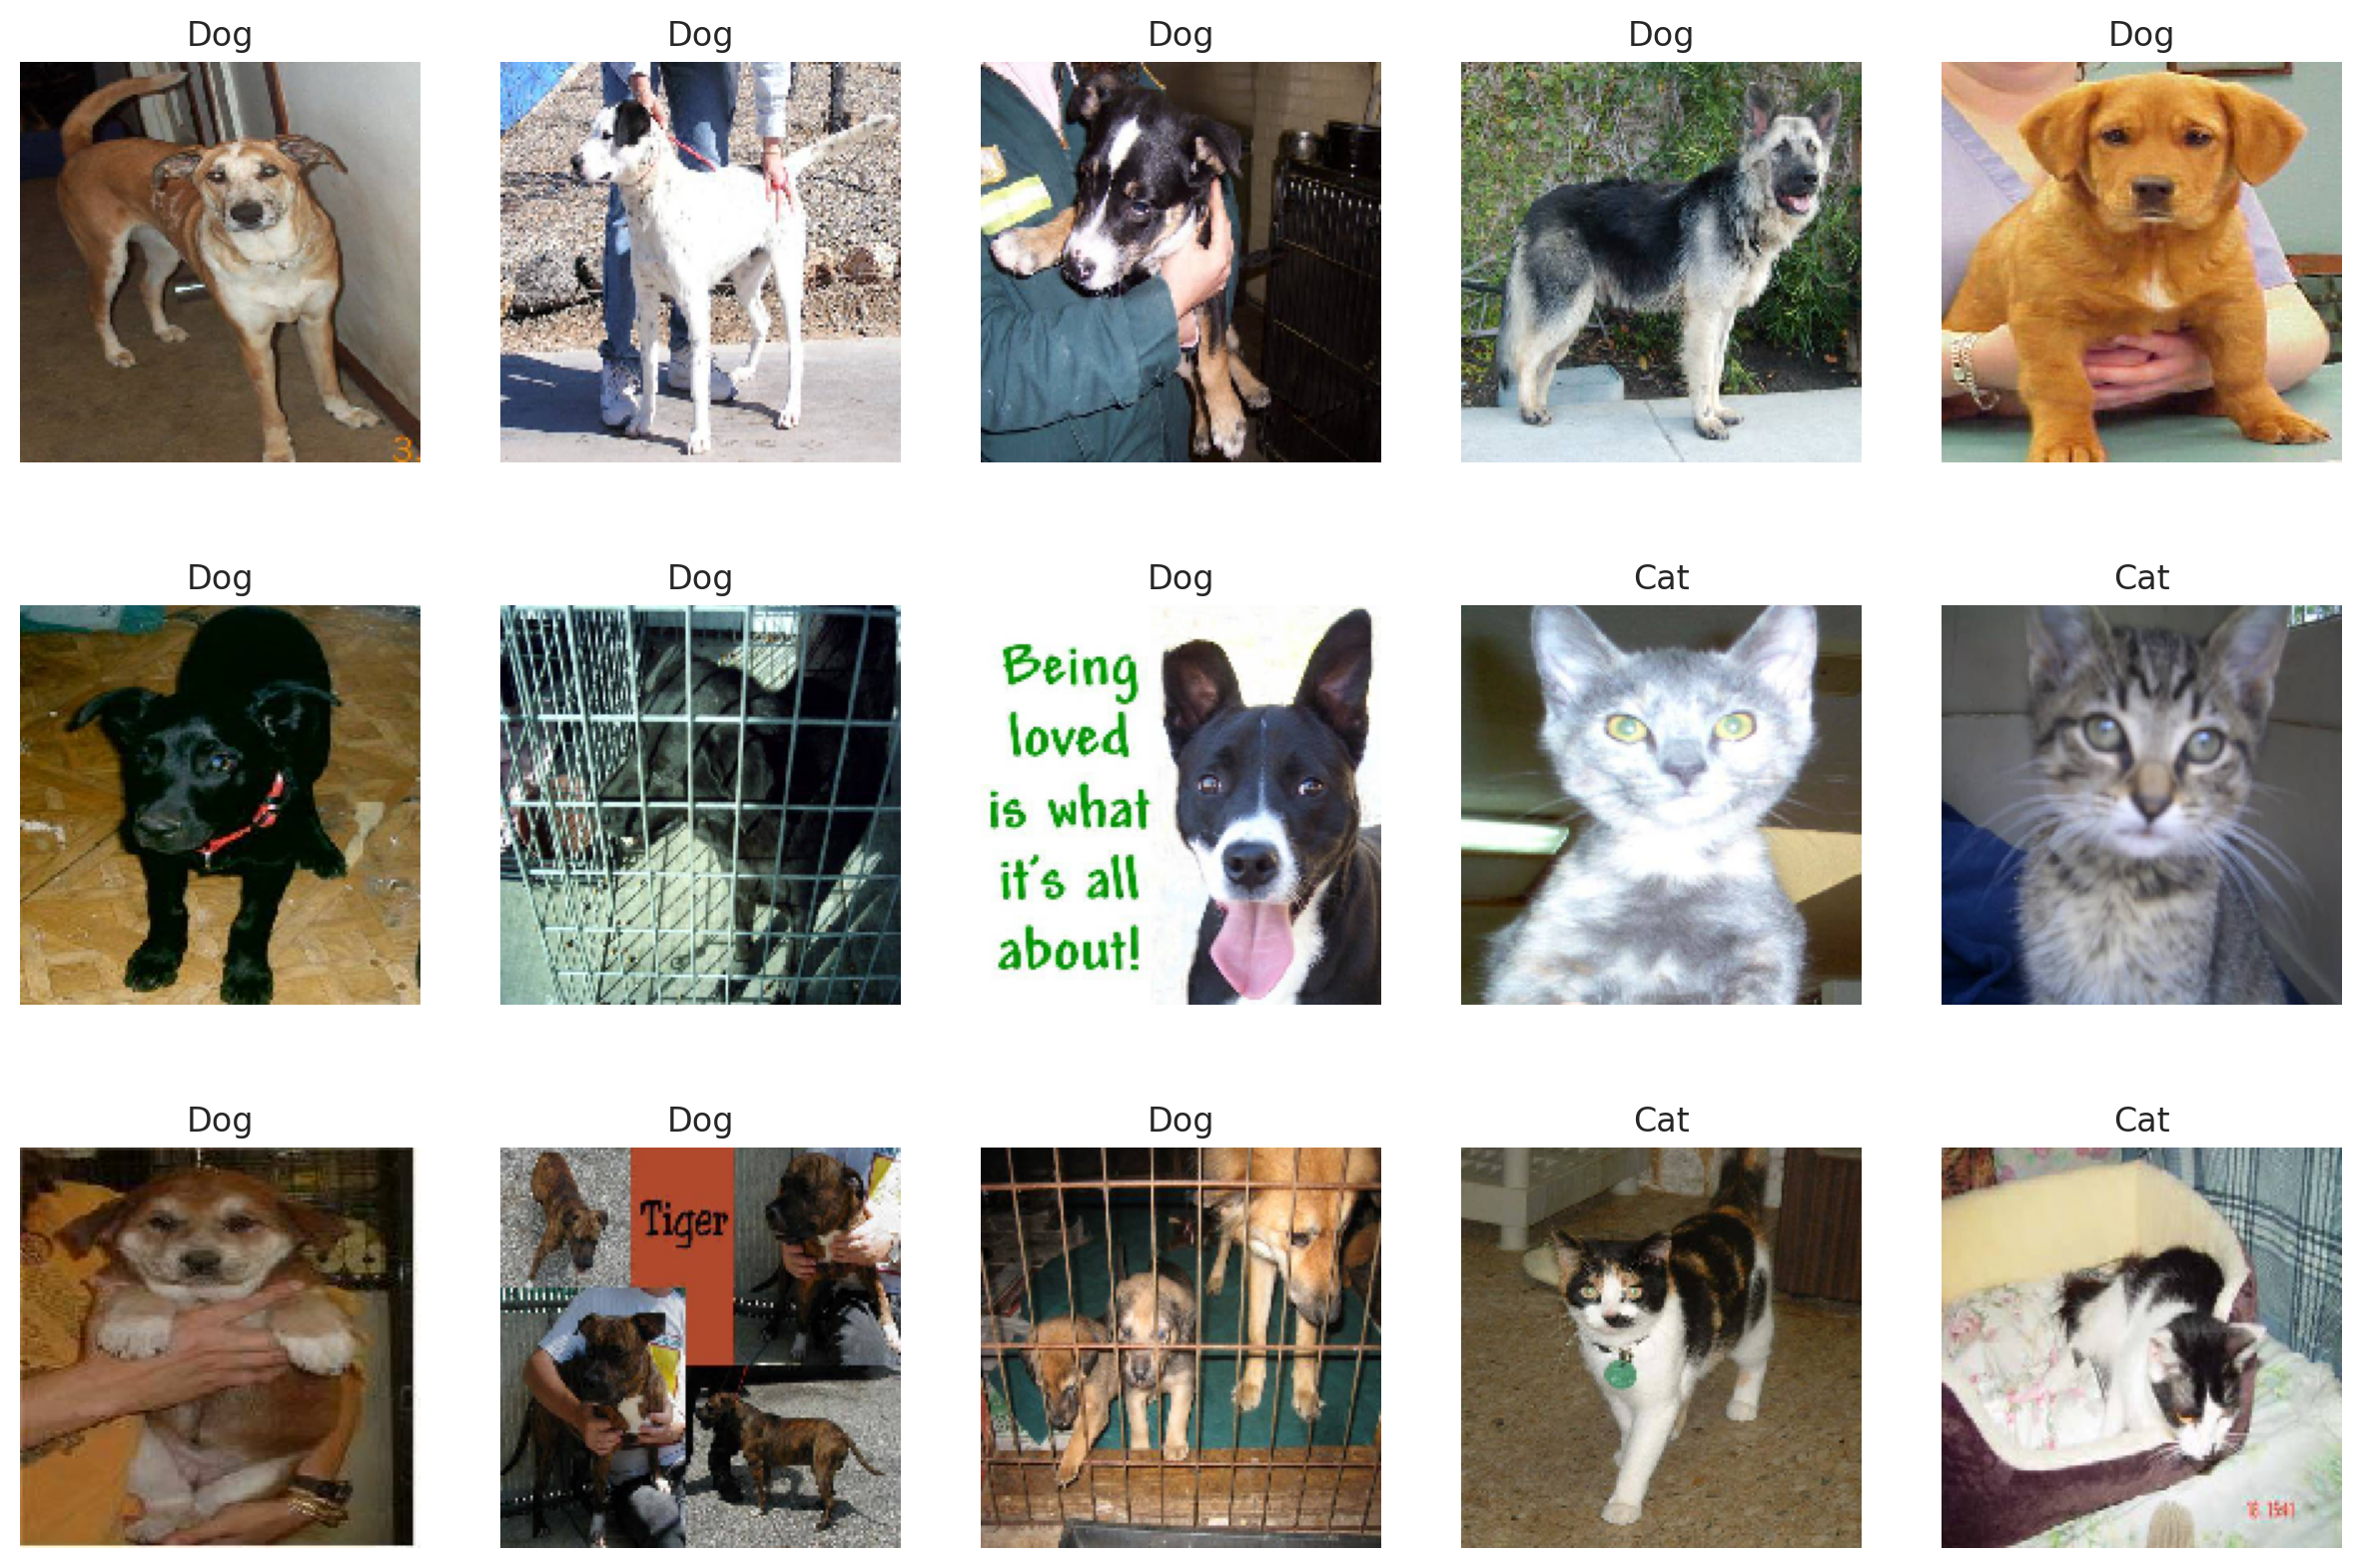

In [4]:
# Display a few images and labels

def plot_images(images, labels):
    """
    This function takes random sample of images and corresponding labels,
    and display them in a figure.
    """
    
    fig = plt.figure(figsize=(15, 10))
    for i in range(15):
        ax = fig.add_subplot(3, 5, i+1)
        ax.set_axis_off()
        ax.imshow(images[i])
        ax.set_title(labels[i])
    plt.show()

# Choose random 15 samples of train dataset
rand_idx = np.random.choice(images_train.shape[0], 15, replace=False)
class_names = np.array(['Dog', 'Cat'])
images, labels = images_train[rand_idx], class_names[labels_train[rand_idx]]

# Plot the images and labels
plot_images(images, labels)

#### Create a benchmark model

We will first train a CNN classifier model as a benchmark model before implementing the transfer learning approach. Using the functional API, build the benchmark model according to the following specifications:

* The model should use the `input_shape` in the function argument to set the shape in the Input layer.
* The first and second hidden layers should be Conv2D layers with 32 filters, 3x3 kernel size and ReLU activation.
* The third hidden layer should be a MaxPooling2D layer with a 2x2 window size.
* The fourth and fifth hidden layers should be Conv2D layers with 64 filters, 3x3 kernel size and ReLU activation.
* The sixth hidden layer should be a MaxPooling2D layer with a 2x2 window size.
* The seventh and eighth hidden layers should be Conv2D layers with 128 filters, 3x3 kernel size and ReLU activation.
* The ninth hidden layer should be a MaxPooling2D layer with a 2x2 window size.
* This should be followed by a Flatten layer, and a Dense layer with 128 units and ReLU activation
* The final layer should be a Dense layer with a single neuron and sigmoid activation.
* All of the Conv2D layers should use `'SAME'` padding.

In total, the network should have 13 layers (including the `Input` layer).

The model should then be compiled with the RMSProp optimiser with learning rate 0.001, binary cross entropy loss and and binary accuracy metric.

In [5]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_benchmark_model(input_shape):
    """
    This function should build and compile a CNN model according to the above
    specification, using the functional API. The function takes input_shape as
    an argument, which should be used to specify the shape in the Input layer.
    Your function should return the model.
    """
    
    inputs = tf.keras.Input(shape=input_shape)
    h = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3),
        activation='relu', padding='SAME')(inputs)
    h = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3),
        activation='relu', padding='SAME')(h)
    h = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(h)
    h = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
        activation='relu', padding='SAME')(h)
    h = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
        activation='relu', padding='SAME')(h)
    h = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(h)
    h = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3),
        activation='relu', padding='SAME')(h)
    h = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3),
        activation='relu', padding='SAME')(h)
    h = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(h)
    h = tf.keras.layers.Flatten()(h)
    h = tf.keras.layers.Dense(units=128, activation='relu')(h)
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(h)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()])
    
    return model

In [7]:
# Build and compile the benchmark model, and display the model summary

benchmark_model = get_benchmark_model(images_train[0].shape)
benchmark_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 160, 160, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 80, 80, 64)        36928     
                                                           

#### Train the CNN benchmark model

We will train the benchmark CNN model using an `EarlyStopping` callback. Feel free to increase the training time if you wish.

In [ ]:
# Fit the benchmark model and save its training history

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=2, verbose=0)

history_benchmark = benchmark_model.fit(
    x=images_train, y=labels_train,
    validation_data=(images_valid, labels_valid),
    epochs=10, batch_size=32, callbacks=[early_stopping],
    verbose=0)

#### Plot the learning curves

In [9]:
class PlotHistory():
    """
    This function should plot learning curves vs epoches.
    The function takes history and metrics as arguments,
    and return the figures.
    """
    plt_nrows = 1
    plt_ncols = 2
    plt_figsize = (15, 5)
    
    def __init__(self, history, metrics=['loss']):
        super().__init__()
        self.history = history
        self.metrics = metrics
        
    @classmethod
    def _create_plot(cls):
        return plt.subplots(nrows=cls.plt_nrows,
            ncols=cls.plt_ncols, figsize=cls.plt_figsize)
    
    def plot(self):
        df_history = pd.DataFrame(self.history.history,
            index=self.history.epoch)
        fig, axes = self._create_plot()
        for ax, metric in zip(axes, self.metrics):
            sns.lineplot(ax=ax, data=df_history,
                x=df_history.index+1, y=metric, label='train')
            try:
                sns.lineplot(ax=ax, data=df_history,
                    x=df_history.index+1, y=f'val_{metric}', label='valid')
            except Exception:
                pass
            ax.legend(loc='best')
            ax.set_xlabel('epoch')
            ax.set_ylabel(f'{metric}')
            ax.set_title(f'{metric} vs. epoch')
        fig.tight_layout()
        plt.show()

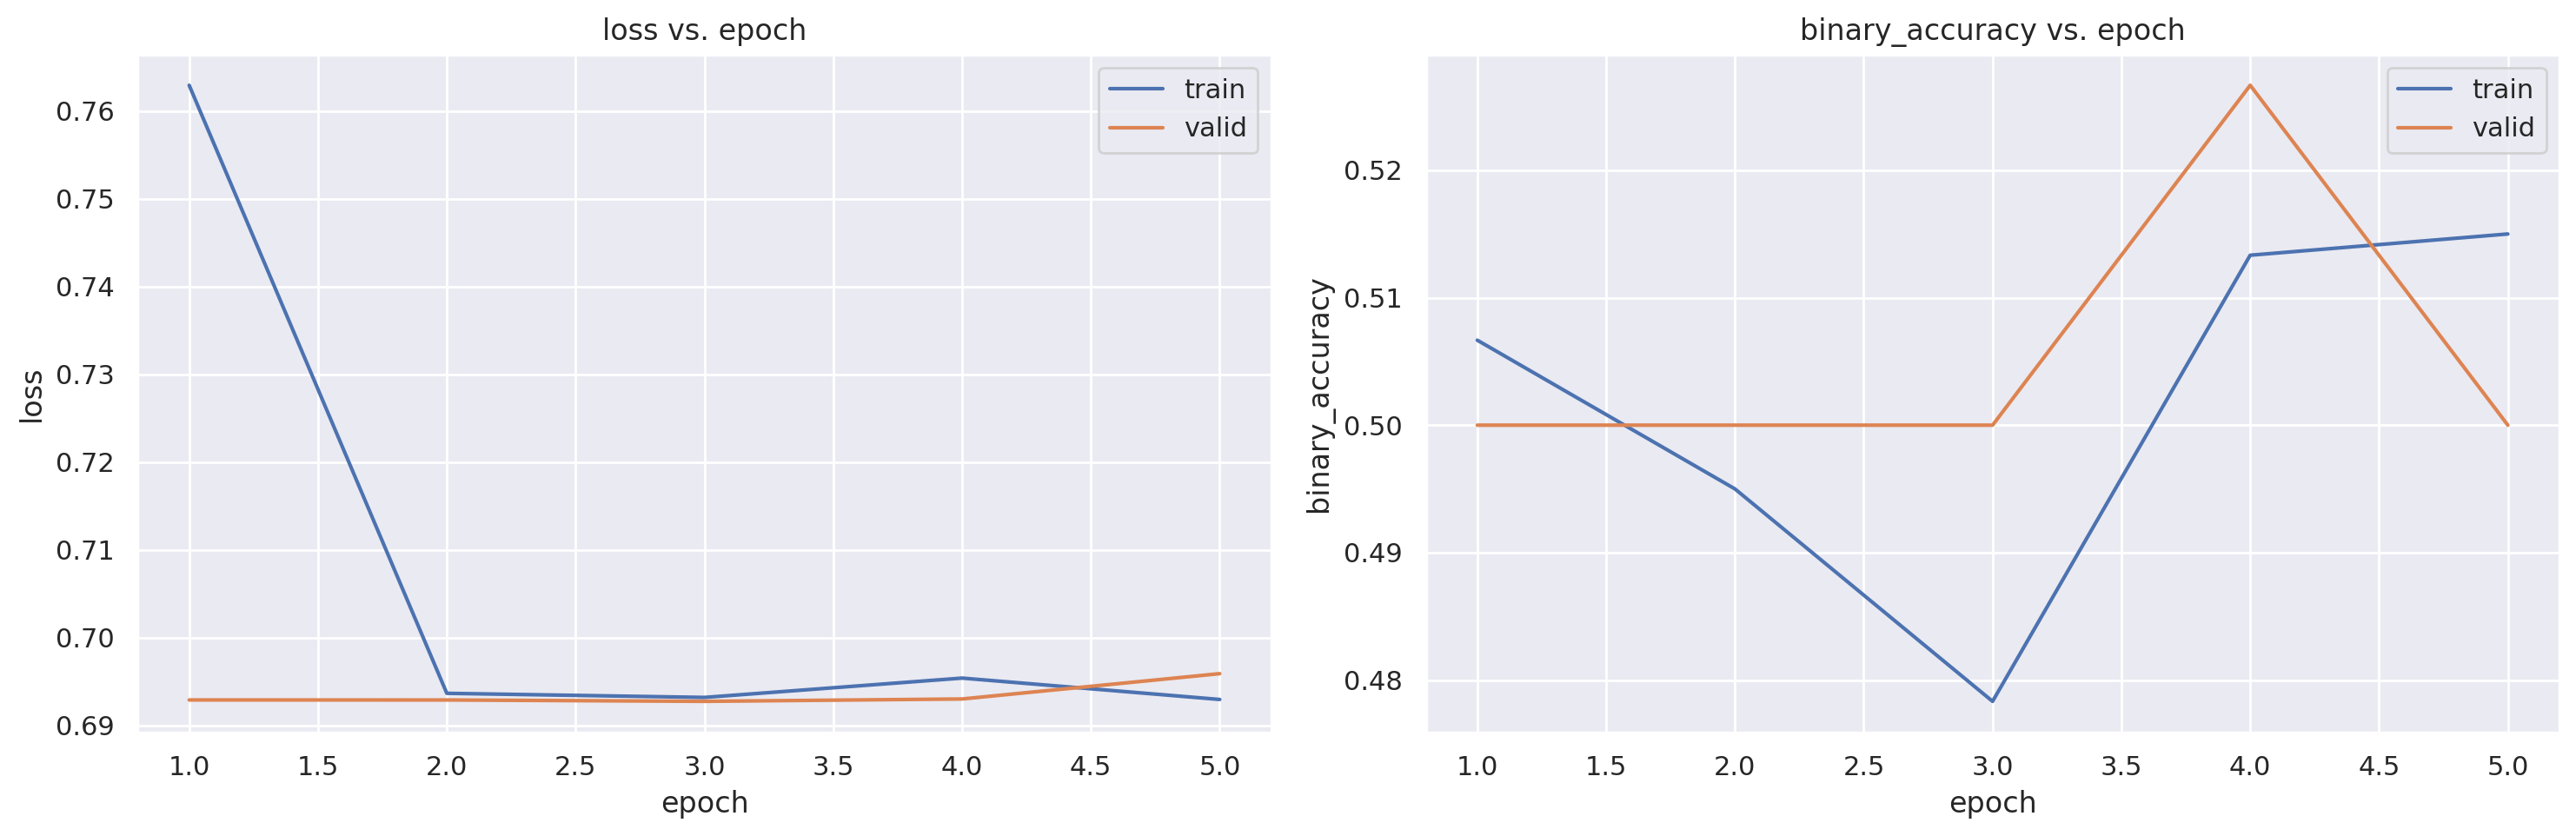

In [10]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

PlotHistory(history_benchmark, metrics=['loss', 'binary_accuracy']).plot()

#### Evaluate the benchmark model

In [11]:
# Evaluate the benchmark model on the test set

benchmark_test_loss, benchmark_test_acc = benchmark_model.evaluate(
    x=images_test, y=labels_test, verbose=0)
print(f"Test loss: {benchmark_test_loss:.4f}")
print(f"Test accuracy: {benchmark_test_acc:.4f}")

Test loss: 0.6967
Test accuracy: 0.5000


#### Load the pretrained image classifier model

You will now begin to build our image classifier using transfer learning.
You will use the pre-trained MobileNet V2 model, available to download from [Keras Applications](https://keras.io/applications/#mobilenetv2). You should download this model (the filename is `MobileNetV2.h5`) and store it in `model` folder.

In [12]:
os.makedirs("./models", exist_ok=True)

tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(160, 160, 3))\
    .save(filepath="models/MobileNetV2.h5")

14536120/14536120 [==============================] - 5s 0us/step


In [13]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def load_pretrained_MobileNetV2(path):
    """
    This function takes a path as an argument, and uses it to load the full
    MobileNetV2 pretrained model from the path. Your function should return 
    the loaded model.
    """
    
    return tf.keras.models.load_model(filepath=path)

In [14]:
# Call the function loading the pretrained model and display its summary

base_model = load_pretrained_MobileNetV2(
    path='models/MobileNetV2.h5')
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

#### Use the pre-trained model as a feature extractor

You will remove the final layer of the network and replace it with new, untrained classifier layers for our task. You will first create a new model that has the same input tensor as the MobileNetV2 model, and uses the output tensor from the layer with name `global_average_pooling2d` as the model output.

In [15]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def remove_head(pretrained_model):
    """
    This function should create and return a new model, using the input and output 
    tensors as specified above. Use the 'get_layer' method to access the correct 
    layer of the pre-trained model.
    """
    
    return tf.keras.Model(
        inputs=pretrained_model.input,
        outputs=pretrained_model.get_layer(name='global_average_pooling2d').output
    )

In [16]:
# Call the function removing the classification head and display the summary

feature_extractor = remove_head(base_model)
feature_extractor.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']         

You can now construct new final classifier layers for your model. Using the Sequential API, create a new model according to the following specifications:

* The new model should begin with the feature extractor model.
* This should then be followed with a new dense layer with 32 units and ReLU activation function.
* This should be followed by a dropout layer with a rate of 0.5.
* Finally, this should be followed by a Dense layer with a single neuron and a sigmoid activation function.

In total, the network should be composed of the pretrained base model plus 3 layers.

In [17]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def add_new_classifier_head(feature_extractor_model):
    """
    This function takes the feature extractor model as an argument,
    and should create and return a new model according to the above specification.
    """
    
    model = tf.keras.Sequential([
        feature_extractor_model,
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    
    return model

In [18]:
# Call the function adding a new classification head and display the summary

new_model = add_new_classifier_head(feature_extractor)
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 32)                40992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,299,009
Trainable params: 2,264,897
Non-trainable params: 34,112
_________________________________________________________________


#### Freeze the weights of the pretrained model

You will now need to freeze the weights of the pre-trained feature extractor, so that only the weights of the new layers you have added will change during the training. 

You should then compile your model as before: use the RMSProp optimiser with learning rate 0.001, binary cross entropy loss and and binary accuracy metric.

In [19]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def freeze_pretrained_weights(model):
    """
    This function should freeze the weights of the pretrained base model.
    Your function should return the model with frozen weights.
    """
    
    model.get_layer(name="model_2").trainable = False
    
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()])
    
    return model

In [20]:
# Call the function freezing the pretrained weights and display the summary

frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 32)                40992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,299,009
Trainable params: 41,025
Non-trainable params: 2,257,984
_________________________________________________________________


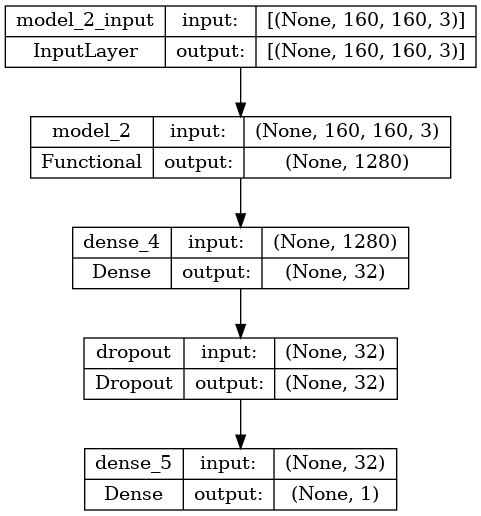

In [21]:
# Plot the model

tf.keras.utils.plot_model(
    model=frozen_new_model,
    to_file='frozen_new_model.png',
    show_shapes=True
)

#### Train the model

You are now ready to train the new model on the dogs vs cats data subset. We will use an `EarlyStopping` callback with patience set to 2 epochs, as before. Feel free to increase the training time if you wish.

In [22]:
# Train the model and save its training history

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=2, verbose=0)

history_frozen_new_model = frozen_new_model.fit(
    x=images_train, y=labels_train,
    validation_data=(images_valid, labels_valid),
    epochs=10, batch_size=32, callbacks=[early_stopping],
    verbose=0)

#### Plot the learning curves

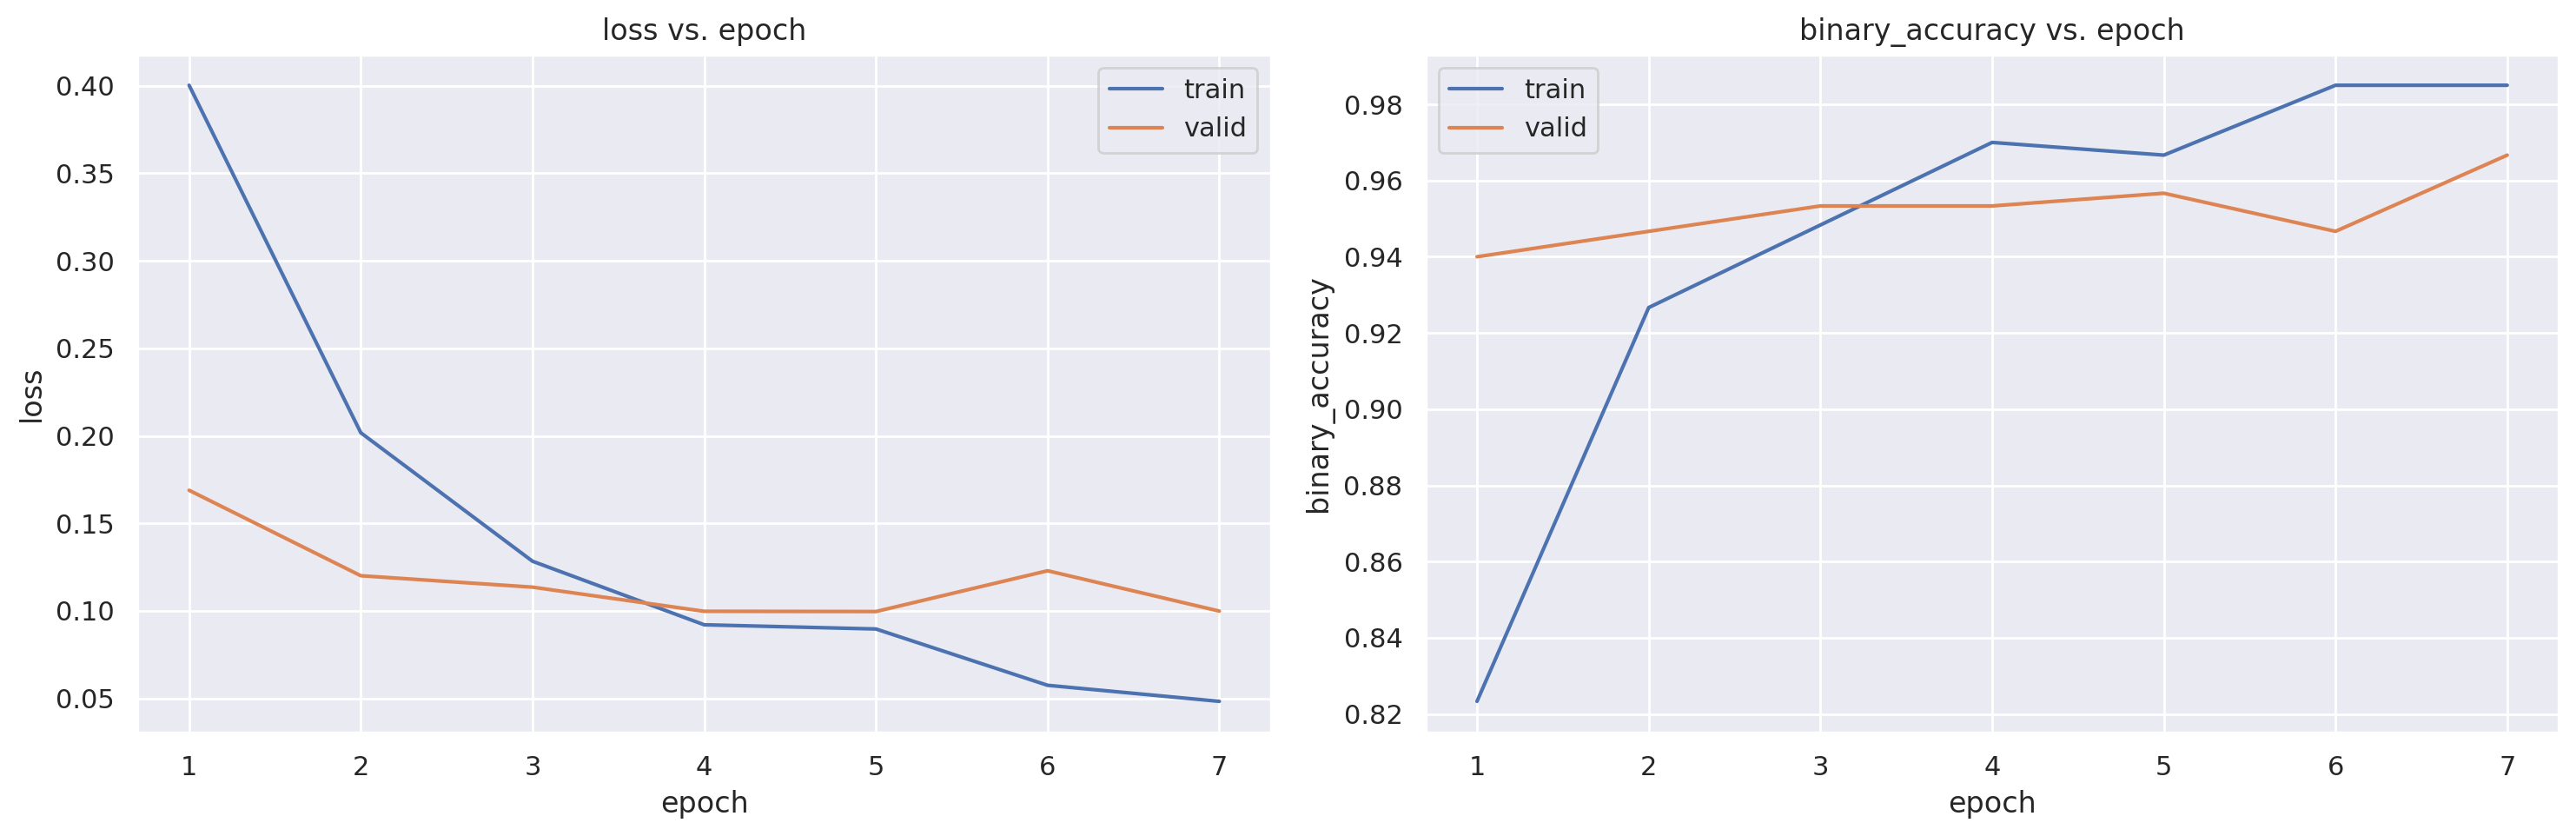

In [23]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

PlotHistory(history_frozen_new_model, metrics=['loss', 'binary_accuracy']).plot()

#### Evaluate the new model

In [24]:
# Evaluate the new model on the test set

new_model_test_loss, new_model_test_acc = frozen_new_model.evaluate(
    x=images_test, y=labels_test, verbose=0)
print(f"Test loss: {new_model_test_loss:.4f}")
print(f"Test accuracy: {new_model_test_acc:.4f}")

Test loss: 0.0766
Test accuracy: 0.9633


#### Compare both models

Finally, we will look at the comparison of training, validation and test metrics between the benchmark and transfer learning model.

In [25]:
# Gather the benchmark and new model metrics

benchmark_train_loss = history_benchmark.history['loss'][-1]
benchmark_valid_loss = history_benchmark.history['val_loss'][-1]

try:
    benchmark_train_acc = history_benchmark.history['acc'][-1]
    benchmark_valid_acc = history_benchmark.history['val_acc'][-1]
except KeyError:
    benchmark_train_acc = history_benchmark.history['binary_accuracy'][-1]
    benchmark_valid_acc = history_benchmark.history['val_binary_accuracy'][-1]

new_model_train_loss = history_frozen_new_model.history['loss'][-1]
new_model_valid_loss = history_frozen_new_model.history['val_loss'][-1]

try:
    new_model_train_acc = history_frozen_new_model.history['acc'][-1]
    new_model_valid_acc = history_frozen_new_model.history['val_acc'][-1]
except KeyError:
    new_model_train_acc = history_frozen_new_model.history['binary_accuracy'][-1]
    new_model_valid_acc = history_frozen_new_model.history['val_binary_accuracy'][-1]

In [26]:
# Compile the metrics into a pandas DataFrame and display the table

comparison_table = pd.DataFrame([
    ['Training loss', benchmark_train_loss, new_model_train_loss],
    ['Training accuracy', benchmark_train_acc, new_model_train_acc],
    ['Validation loss', benchmark_valid_loss, new_model_valid_loss],
    ['Validation accuracy', benchmark_valid_acc, new_model_valid_acc],
    ['Test loss', benchmark_test_loss, new_model_test_loss],
    ['Test accuracy', benchmark_test_acc, new_model_test_acc]],
    columns=['Metric', 'Benchmark CNN', 'Transfer learning CNN'])
comparison_table.index=['']*6
comparison_table

Metric  Benchmark CNN  Transfer learning CNN
        Training loss       0.692951               0.048337
    Training accuracy       0.515000               0.985000
      Validation loss       0.695892               0.099901
  Validation accuracy       0.500000               0.966667
            Test loss       0.696706               0.076589
        Test accuracy       0.500000               0.963333

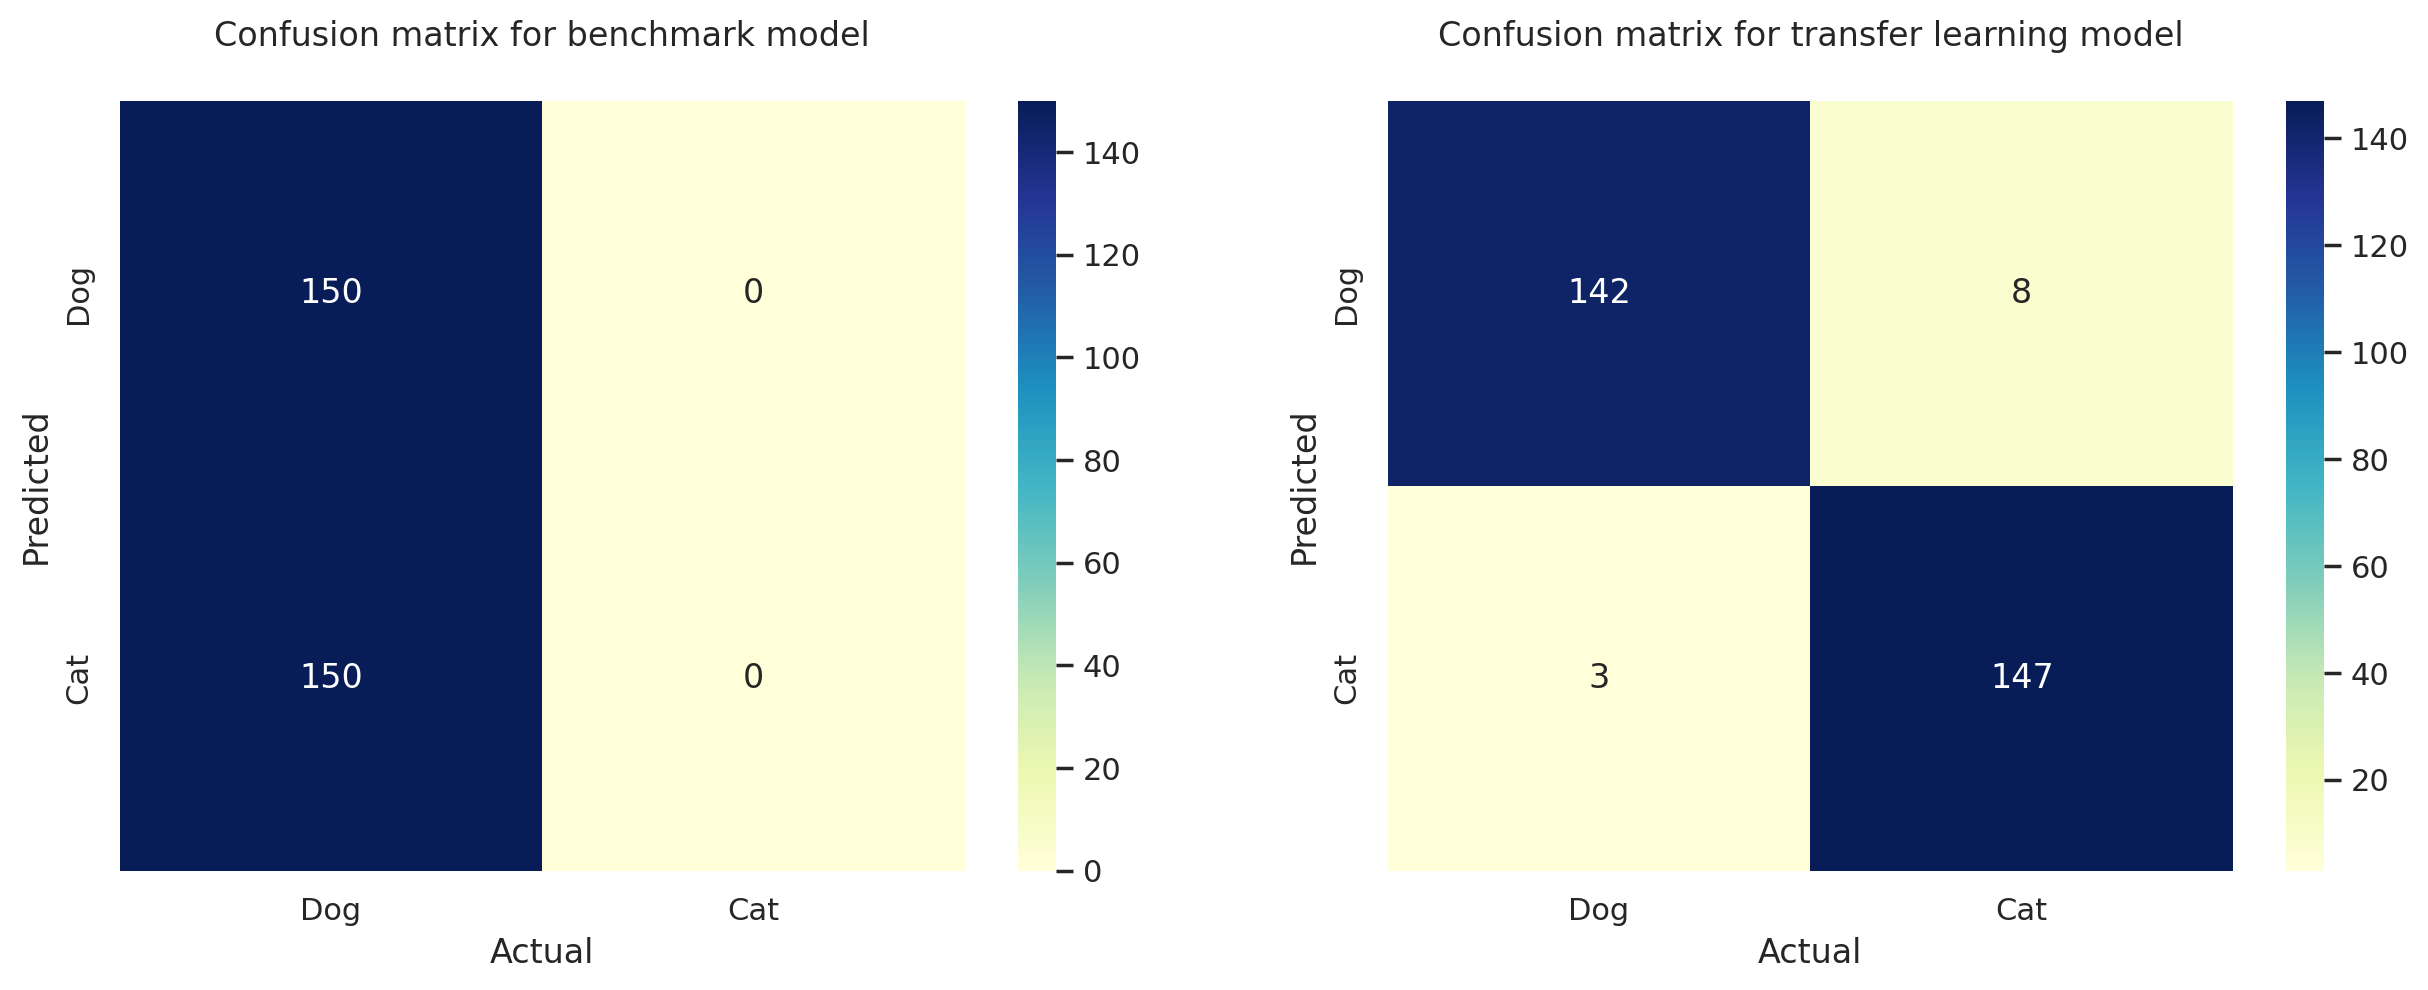

In [27]:
# Plot confusion matrices for benchmark and transfer learning models

plt.figure(figsize=(15, 5))

preds = benchmark_model.predict(
    x=images_test, verbose=0)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(
    y_true=labels_test, y_pred=preds)
df_cm = pd.DataFrame(data=cm,
    index=['Dog', 'Cat'], columns=['Dog', 'Cat'])
plt.subplot(121)
plt.title("Confusion matrix for benchmark model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

preds = frozen_new_model.predict(
    x=images_test, verbose=0)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(
    y_true=labels_test, y_pred=preds)
df_cm = pd.DataFrame(data=cm,
    index=['Dog', 'Cat'], columns=['Dog', 'Cat'])
plt.subplot(122)
plt.title("Confusion matrix for transfer learning model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

Congratulations for completing this programming assignment! In the next week of the course we will learn how to develop an effective data pipeline.